 <h1> <center> <b> Explainable AI on image data using LIME </b> </center> </h1> 
 
  This code is sourced from https://www.youtube.com/watch?v=bHGrRrJUje8

Here is a simpler example of the use of LIME for image classification by using Keras (v2 or greater)

In [ ]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

# Using Inception
Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

Inception V3, a convolutional neural network architecture designed by Google, can predict 1000 different classes. This is because it is typically trained on the ImageNet dataset, which contains 1000 distinct categories of objects. The network outputs a probability distribution over these 1000 classes for each input image.

In [3]:
inet_model = inc_net.InceptionV3()

**Function to Preprocess Image Paths for InceptionV3 Model Input**

The transform_img_fn function preprocesses a list of image paths into a batch suitable for InceptionV3 input.

In [ ]:
def transform_img_fn(path_list):
    out = []  # Initialize an empty list to store processed images
    for img_path in path_list:  # Loop through each image path
        img = image.load_img(img_path, target_size=(299, 299))  # Load and resize image
        x = image.img_to_array(img)  # Convert image to a NumPy array
        x = np.expand_dims(x, axis=0)  # Add an extra dimension for batch processing
        x = inc_net.preprocess_input(x)  # Preprocess the image for InceptionV3
        out.append(x)  # Append the processed image to the list
    return np.vstack(out)  # Stack all images into a single batch and return

## Let's see the top 5 prediction for some image

**Load, Preprocess, and Predict Image using InceptionV3 Model**

The code loads and preprocesses an image, displays it, and then uses the InceptionV3 model to make predictions, printing the decoded results.

In [ ]:
# For this part, we need to add a separate data folder and upload the images. Subsequesntly, copy the path to the following

images = transform_img_fn([os.path.join('data','Tiger-1.jpg')])  # Load and preprocess the image
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images; if 0.5 not added makes image dark
plt.imshow(images[0] / 2 + 0.5)  # Display the image; dividing by 2 and adding 0.5 adjusts pixel values for visualization
preds = inet_model.predict(images)  # Predict the image class using the InceptionV3 model
for x in decode_predictions(preds)[0]:  # Decode and print the prediction results
    print(x)

## Explanation
Now let's get an explanation

In [ ]:
pip install lime

**Automatically Reload Modules and Ensure LIME Package is Available**

The code configures automatic module reloading and ensures the lime package is imported, adding its directory to the system path if necessary.

In [ ]:
# Load the autoreload extension to automatically reload modules before executing code
%load_ext autoreload
%autoreload 2

import os,sys  # Import required modules

# Try to import the lime package, adding its directory to the system path if not found
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime


**Initialize LIME Image Explainer**

The code initializes an instance of the LIME image explainer for interpreting image classification models.

In [ ]:
from lime import lime_image  # Import the LIME image explainer module
explainer = lime_image.LimeImageExplainer()  # Initialize the LIME image explainer

**Generate LIME Explanation for Image Prediction**

The code generates a LIME explanation for the InceptionV3 model's prediction on the given image.

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [ ]:
%%time
# Generate a LIME explanation for the image prediction
# 'images[0].astype('double')' ensures the image is in the correct format
# 'inet_model.predict' is the prediction function
# 'top_labels=5' specifies the number of top labels to explain
# 'hide_color=0' sets the color for a superpixel turned off (black). Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels.
# 'num_samples=1000' is the number of samples to generate for the explanation
explanation = explainer.explain_instance(
    images[0].astype('double'), 
    inet_model.predict, 
    top_labels=5, 
    hide_color=0, 
    num_samples=1000
    )

### Now let's see the explanation for the top class

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

**Import Function to Mark Boundaries on Segmented Images**

The code imports the mark_boundaries function from the skimage.segmentation module to visualize the boundaries of superpixels on images.

In [ ]:
from skimage.segmentation import mark_boundaries  # Import the function to mark boundaries of superpixels on images

**Visualize LIME Explanation with Superpixel Boundaries**

The code extracts and visualizes the LIME explanation by marking superpixel boundaries on the image, highlighting regions important for the top predicted label.

In [ ]:
# Get the image and mask for the top predicted label from the LIME explanation
# 'positive_only=True' shows only the superpixels contributing positively to the prediction
# 'num_features=5' displays the top 5 superpixels
# 'hide_rest=True' hides the other parts of the image
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True
)

# Display the image with marked boundaries of the superpixels
# 'temp / 2 + 0.5' adjusts pixel values for visualization
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or with the rest of the image present:

In [ ]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
    )
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

**Visualize LIME Explanation with Top 5 Superpixel Boundaries (Both Positive and Negative Contributions)**

We can also see the 'pros and cons' (pros in green; positive contributions, cons in red; negative contributions)

In [ ]:
# 'positive_only=False' shows both positive and negative contributing superpixels
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=False, 
    num_features=10, 
    hide_rest=False
    )
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or the pros and cons that have weight at least 0.1

In [ ]:
# 'min_weight=0.1' only includes superpixels with a minimum weight of 0.1
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=False, 
    num_features=1000, 
    hide_rest=False, 
    min_weight=0.05
    )
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Alternatively, we can also plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.

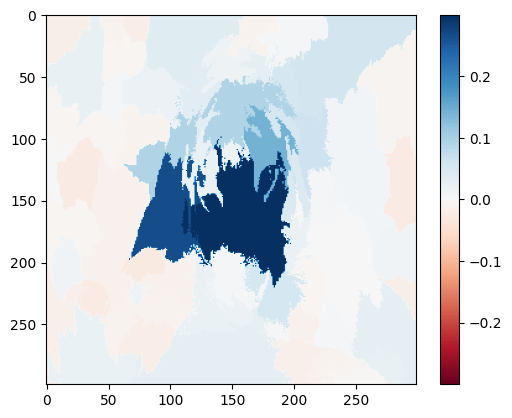

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

### Let's see the explanation for the second highest prediction

Most positive towards wombat:

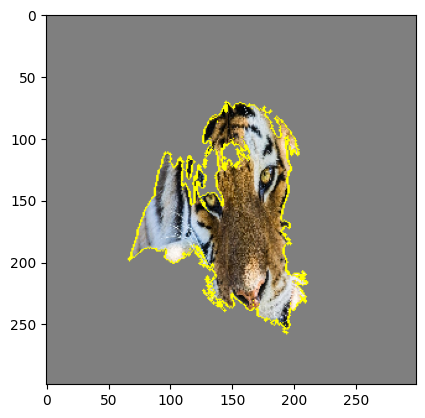

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=6, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

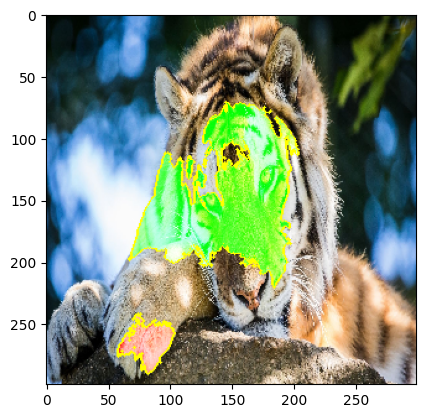

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
